In [22]:
import torch
import torch.optim as optim
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

# Dataset

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
ID: 0, Label: paper
ID: 1, Label: metal
ID: 2, Label: plastic
ID: 3, Label: glass
ID: 4, Label: food
ID: 5, Label: hazardous
ID: 6, Label: electronic
1586


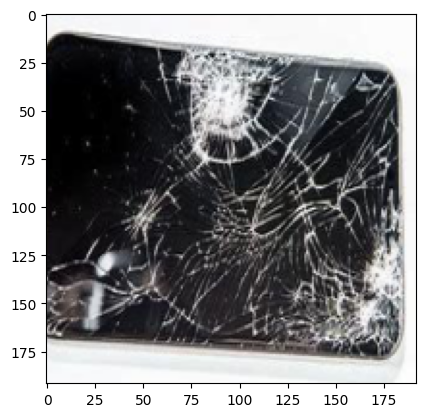

In [23]:
import numpy as np
import torch.utils.data as data
from pycocotools.coco import COCO
import os

from PIL import Image
from torchvision.transforms import functional as F


class MyCOCODataset(data.Dataset):
    def __init__(self, data_root, annofile, output_size=(192, 192)):
        self.data_root = data_root
        self.annofile = annofile
        self.coco = COCO(annofile)
        self.instance_ids = list(self.coco.anns.keys())
        self.instances = self.coco.anns
        self.output_size = output_size

    def __getitem__(self, index):
        id = self.instance_ids[index]
        ann = self.instances[id]
        imgid = ann["image_id"]
        # [x, y , w, h]
        bbox = ann["bbox"]
        img_file = self.coco.loadImgs([imgid])[0]["file_name"]
        img = Image.open(os.path.join(self.data_root, img_file))

        # cutout the instance from bbox
        _bbox_int = list(map(int, bbox))
        img = img.crop(
            (
                _bbox_int[0],  # x1
                _bbox_int[1],  # y1
                _bbox_int[0] + _bbox_int[2],  # x2 = x1 + w
                _bbox_int[1] + _bbox_int[3],  # y2 = y1 + h
            )
        )
        # resize the iamge to corresponding size
        img = img.resize(self.output_size, Image.BILINEAR)
        if img.mode == "L":
            img = img.convert("RGB")

        # convert image to tensor
        img = np.array(img)

        # handle the annotation
        category = ann["category_id"]
        category = np.array(category, dtype=np.int64)

        assert img.shape[0] == self.output_size[0]
        assert img.shape[1] == self.output_size[1]
        assert img.shape[2] == 3

        return img, category

    def __len__(self):
        return len(self.instance_ids)

    # utility function to print all categories
    def print_all_categories(self):
        for id, category in self.coco.cats.items():
            print(f'ID: {id}, Label: {category["name"]}')

### START CODE HERE ### (≈ 1 line of code) 
# Complete the loading of the data set: 
# e.g., dataset = MyCOCODataset(Path = '',Json = '')

dataset = MyCOCODataset(
    "./data/train_data",
    "./data/train_data/annotations.json",
)

### END CODE HERE ###
dataset.print_all_categories()
print(len(dataset))
img, label = dataset[0]
plt.imshow(img)

# Model (Here you can change the deep learning model)

In [24]:
from functools import partial
from typing import Any, Optional

import torch
import torch.nn as nn


class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()

        # NOTE: visual backbone

        ### START CODE HERE ### (≈ 1 line of code) 
        # you need to Build AlexNet network
        # e.g., self.features = nn.Sequential(,,,,,)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        ### END CODE HERE ###

        # [batch, 256, 6,6]
        # NOTE: header, stduent filling
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        ### START CODE HERE ### (≈ 1 line of code) 
        # you need to Build classifier layer
        # e.g., self.classifier = nn.Sequential(,,,,,)
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        ### END CODE HERE ###

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# test code
model = AlexNet(num_classes=1000)
x = torch.randn(1, 3, 192, 192)
print(model(x).shape)


torch.Size([1, 1000])


# Trainining

In [25]:
lr = 1e-4
device = "cuda"
batch_size = 32
num_classes = 7
num_epoch = 10

model = AlexNet(num_classes=num_classes).to(device)

tran_set = MyCOCODataset(
    "data/train_data",
    "data/train_data/annotations.json",
)
val_set = MyCOCODataset(
    "data/val_data",
    "data/val_data/annotations.json",
)

trainloader, val_loader = (
    DataLoader(tran_set, batch_size=batch_size, shuffle=True),
    DataLoader(val_set, batch_size=batch_size, shuffle=True),
)




loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
for epoch in range(num_epoch):  # loop over the dataset multiple times
    # trainning loop
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images, labels = data

        # NOTE: the input data should be normalized to [0, 1]
        # or to distribution with mean 0 and std 1
        images = images.float() / 255.0

        # NOTE: the input shape for Pytorch should be [batch_size, channels, height, width]
        # so we need to transpose the input data
        images = images.permute(0, 3, 1, 2)

        images, labels = images.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        print(f"a batch done, batch id: {i} loss: {loss.item()}")

    # validation loop
    best_accuracy = 0
    validate_predicte = []
    validate_ground_truth = []
    with torch.no_grad():
        for data in val_loader:
            images, labels = data

            # data preprocessing
            images = images.float() / 255.0
            images = images.permute(0, 3, 1, 2)

            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            validate_predicte.append(predictions.detach())
            validate_ground_truth.append(labels.detach())

    # calulate the accuracy
    validate_predicte = torch.cat(validate_predicte)
    validate_ground_truth = torch.cat(validate_ground_truth)
    correct = (validate_predicte == validate_ground_truth).sum().item()
    accuracy = correct / len(validate_ground_truth)

    # save checkpoint if the accuracy is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), "outputs/best_model.pth")

    print(f"epoch: {epoch} accuracy: {accuracy}")

a batch done, batch id: 0 loss: 1.9459770917892456
a batch done, batch id: 1 loss: 1.9500253200531006
a batch done, batch id: 2 loss: 1.9467861652374268
a batch done, batch id: 3 loss: 1.947873830795288
a batch done, batch id: 4 loss: 1.9420937299728394
a batch done, batch id: 5 loss: 1.9521514177322388
a batch done, batch id: 6 loss: 1.946499228477478
a batch done, batch id: 7 loss: 1.9485920667648315
a batch done, batch id: 8 loss: 1.9542416334152222
a batch done, batch id: 9 loss: 1.9491180181503296
a batch done, batch id: 10 loss: 1.9400243759155273
a batch done, batch id: 11 loss: 1.9354060888290405
a batch done, batch id: 12 loss: 1.9517009258270264
a batch done, batch id: 13 loss: 1.9421796798706055
a batch done, batch id: 14 loss: 1.9408290386199951
a batch done, batch id: 15 loss: 1.9405333995819092
a batch done, batch id: 16 loss: 1.9657044410705566
a batch done, batch id: 17 loss: 1.95831298828125
a batch done, batch id: 18 loss: 1.9539036750793457
a batch done, batch id: 19

# Evaluation (you can also change the confusion matrix colors and also add F1 score matrics)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Accuracy: 0.31190926275992437
tensor([[46., 30., 46., 50., 11., 27., 18.],
        [ 2., 21.,  4.,  6.,  4., 16., 18.],
        [ 4.,  2.,  5.,  2.,  0.,  2.,  1.],
        [ 1.,  7.,  2.,  1.,  0.,  3.,  0.],
        [10., 23., 19., 15., 67., 20.,  6.],
        [ 0.,  2.,  1.,  3.,  0.,  1.,  0.],
        [ 0.,  5.,  1.,  1.,  0.,  2., 24.]])


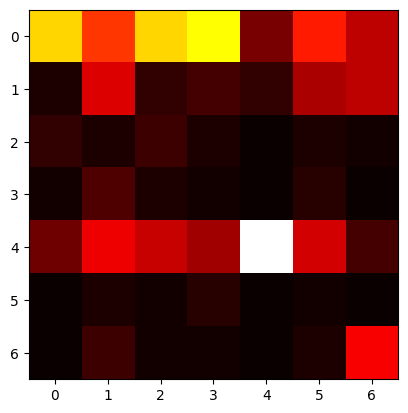

In [27]:
classes = 7
checkpoint_path = "outputs/best_model.pth"
device = "cuda"

def confusion_matrix(predicted, ground_truth, num_classes):
    matrix = torch.zeros(num_classes, num_classes)
    for p, g in torch.stack([predicted, ground_truth], dim=1):
        matrix[p, g] += 1
    return matrix


# reconstruct the model
model = AlexNet(num_classes=classes).to(device)
# read paramerers
ckpt = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(ckpt)

# load test dataaset, similar as the training
test_set = MyCOCODataset(
    "data/test_data",
    "data/test_data/annotations.json",
)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

test_predicte = []
test_ground_truth = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data

        # data preprocessing
        images = images.float() / 255.0
        images = images.permute(0, 3, 1, 2)

        # move device
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        test_predicte.append(predictions.detach())
        test_ground_truth.append(labels.detach())

# calulate the accuracy
test_predicte = torch.cat(test_predicte)
test_ground_truth = torch.cat(test_ground_truth)
correct = (test_predicte == test_ground_truth).sum().item()
accuracy = correct / len(test_ground_truth)
print(f"Accuracy: {accuracy}")

# NOTE: draw confusion matrix
matrix = confusion_matrix(test_predicte, test_ground_truth, classes)
print(matrix)

# NOTE: draw confusion matrix
plt.imshow(matrix, cmap="hot", interpolation="nearest")